In [1]:
from __future__ import print_function
import os
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/Users/candydong/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/candydong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/candydong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/candydong/anaconda/lib/python3.

In [2]:
class Opts():
    def __init__(self):
        self.train_data_path = "./working_v2/train/"
        self.test_data_path = "./working_v2/test/"
        self.csv_path = "./meta"
        self.data_path = "./data/"
        self.model_save_path = "./output/"
        self.model_name = "cnn_v2.h5"
        self.plot_save_path = "./plot/cnn_v2"
        
        if not os.path.exists(self.plot_save_path):
            os.mkdir(self.plot_save_path)
opts = Opts()


In [3]:
model = load_model(os.path.join(opts.model_save_path, opts.model_name))

In [4]:
def df_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

test_csv_path = os.path.join(opts.csv_path, "test.csv")
test_file_df = df_from_csv(test_csv_path)

def append_ext(fn):
    return fn+".jpg"
test_file_df["file_names"] = test_file_df["file_names"].apply(append_ext)

In [5]:
test_data_gen = ImageDataGenerator(rescale=1./255.)
test_gen=test_data_gen.flow_from_dataframe(
    dataframe=test_file_df,
    directory=opts.test_data_path,
    x_col="file_names",
    y_col="class_names",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset() # resets batch index to 0


Found 925 images belonging to 10 classes.


In [6]:
pred=model.predict_generator(test_gen,
                             steps=STEP_SIZE_TEST,
                             verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

28/28 [==============================] - 9s 325ms/step

In [7]:
labels = ['AC', 'CH', 'CP', 'DB', 'DR', 'EI', 'GS', 'JH', 'SI', 'SM']
cm = confusion_matrix([labels[i] for i in test_gen.classes[:896]], \
                      [labels[j] for j in predicted_class_indices], \
                      labels)

# plt.imshow(cm)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")

# plt.xticks(np.arange(0,10),labels)
# plt.yticks(np.arange(0,10),labels)
# plt.title('Confusion Matrix of Baseline CNN')
# plt.colorbar()
# plt.savefig(os.path.join(opts.plot_save_path, "cm(baseline)"), bbox_inches='tight')

# plt.show()

#Fetch labels from train gen for testing
# labels = (train_gen.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          opts,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
        -----
        plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                                  # sklearn.metrics.confusion_matrix
                              normalize    = True,                # show proportions
                              target_names = y_labels_vals,       # list of names of the classes
                              title        = best_estimator_name) # title of graph

        Citiation
        ---------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(opts.plot_save_path, title), bbox_inches='tight')
    plt.show()

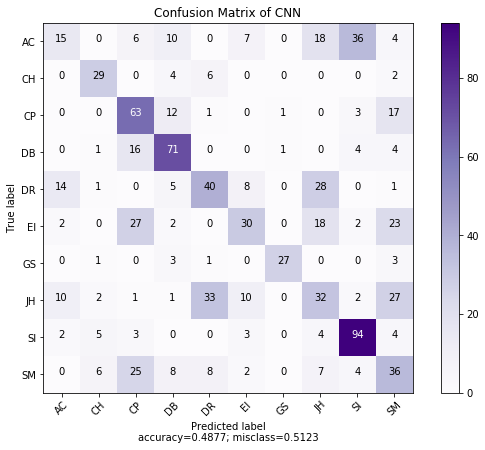

In [9]:
plot_confusion_matrix(cm, 
                      labels,
                      opts,
                      normalize = False,
                      title = "Confusion Matrix of CNN")